# E-Commerce Fraud Detection - Modeling

This notebook trains and evaluates machine learning models for fraud detection using the engineered features from `ec_fraud_detection.ipynb`.

## Project Goal
Deploy an optimally trained classification model capable of identifying fraudulent transactions with high precision and recall.

## Modeling Approach
1. Load pre-engineered features from EDA notebook
2. Model-specific preprocessing (one-hot encoding, scaling)
3. Baseline model training (Logistic Regression, Random Forest, XGBoost)
4. Hyperparameter tuning
5. Model evaluation with fraud-appropriate metrics
6. Final model selection

## Key Challenges
- **Class Imbalance**: 44:1 ratio (97.8% normal, 2.2% fraud)
- **Metric Selection**: **PR-AUC**, ROC-AUC, F1, Precision-Recall (not accuracy)
- **Business Trade-off**: Balance false positives (customer friction) vs false negatives (fraud losses)

## Setup
### Define parameters

In [1]:
# Data paths (relative to notebooks/ folder)
data_path = "../data/transactions.csv"
model_dir = "../models"  # Directory for saving model log files

# Target column
target_col = "is_fraud"

# Random seed for reproducibility (matches train.py)
random_seed = 1

### Import packages

In [2]:
# Add project root to path for imports (needed when running from notebooks/ folder)
import sys
from pathlib import Path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Standard library
import json

# Data handling
import pandas as pd
import numpy as np

# XGBoost
import xgboost as xgb

# Sklearn - preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler

# Sklearn - models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Sklearn - model selection
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline

# Visualization
import matplotlib.pyplot as plt

# Project-specific preprocessing
from src.deployment.preprocessing import FraudFeatureTransformer
from src.deployment.evaluation.metrics import evaluate_model

# fd2 notebook utilities
from src.fd2_nb import (
    compare_models,
    create_search_object,
    tune_with_logging,
    analyze_cv_results,
    track_xgboost_iterations,
    analyze_cv_fold_variance
)

print("All packages imported successfully")


All packages imported successfully


## Load Data
Load the pre-engineered datasets with final selected features from the EDA notebook. Note that test data is completely held out of the model selection and tuning process in this notebook. It is used for final model evaluation in the last notebook, `fd3_model_evaluation_deployment.ipynb`.

In [3]:
# Load raw data and apply production transformer
print("Loading raw transaction data...")
df = pd.read_csv(data_path, low_memory=False)

# Split data (matching train.py exactly)
print(f"Total samples: {len(df):,}")
print(f"Fraud rate: {df[target_col].mean():.2%}")

# 60/20/20 train/val/test split with stratification
train_val_raw, _ = train_test_split(
    df, test_size=0.2, stratify=df[target_col], random_state=random_seed
)
train_raw, val_raw = train_test_split(
    train_val_raw, test_size=0.25, stratify=train_val_raw[target_col], random_state=random_seed
)

print(f"\nSplit sizes:")
print(f"  • Training:   {len(train_raw):,} samples ({len(train_raw)/len(df)*100:.1f}%)")
print(f"  • Validation: {len(val_raw):,} samples ({len(val_raw)/len(df)*100:.1f}%)")

# Apply production feature engineering pipeline
print("\nApplying FraudFeatureTransformer...")
transformer = FraudFeatureTransformer()
transformer.fit(train_raw)  # Fit only on training data

# Transform all datasets
train_features = transformer.transform(train_raw)
val_features = transformer.transform(val_raw)

# Add target column back
train_df = train_features.copy()
train_df[target_col] = train_raw[target_col].values

val_df = val_features.copy()
val_df[target_col] = val_raw[target_col].values

print("✓ Feature engineering complete")
print(f"\nDataset shapes:")
print(f"  • Training:   {train_df.shape}")
print(f"  • Validation: {val_df.shape}")
print(f"  • Features:   {train_features.shape[1]}")

print(f"\nFeature columns:")
print(f"  {list(train_features.columns)}")

Loading raw transaction data...
Total samples: 299,695
Fraud rate: 2.21%

Split sizes:
  • Training:   179,817 samples (60.0%)
  • Validation: 59,939 samples (20.0%)

Applying FraudFeatureTransformer...
✓ Feature engineering complete

Dataset shapes:
  • Training:   (179817, 31)
  • Validation: (59939, 31)
  • Features:   30

Feature columns:
  ['account_age_days', 'total_transactions_user', 'avg_amount_user', 'amount', 'shipping_distance_km', 'channel', 'promo_used', 'avs_match', 'cvv_result', 'three_ds_flag', 'hour_local', 'day_of_week_local', 'month_local', 'is_weekend_local', 'is_late_night_local', 'is_business_hours_local', 'amount_deviation', 'amount_vs_avg_ratio', 'is_micro_transaction', 'is_large_transaction', 'transaction_velocity', 'is_new_account', 'is_high_frequency_user', 'country_mismatch', 'high_risk_distance', 'zero_distance', 'security_score', 'new_account_with_promo', 'late_night_micro_transaction', 'high_value_long_distance']


### Inspect loaded data

In [4]:
# Display first few rows
print("Training data sample:")
display(train_df.head())
display(train_df.info())

# Check target distribution
print("\nTarget distribution (training set):")
fraud_rate = train_df[target_col].mean()
print(train_df[target_col].value_counts())
print(f"\nFraud rate: {fraud_rate:.4f} ({fraud_rate*100:.2f}%)")
print(f"Class imbalance ratio: {(1-fraud_rate)/fraud_rate:.1f}:1")

Training data sample:


,account_age_days,total_transactions_user,avg_amount_user,amount,shipping_distance_km,channel,promo_used,avs_match,cvv_result,three_ds_flag,...,is_new_account,is_high_frequency_user,country_mismatch,high_risk_distance,zero_distance,security_score,new_account_with_promo,late_night_micro_transaction,high_value_long_distance,is_fraud
91794,897,43,87.08,192.52,274.59,web,0,1,1,1,...,0,0,0,0,0,3,0,0,0,0
38975,379,52,23.68,27.00,1205.83,app,0,1,1,1,...,0,0,1,1,0,3,0,0,0,0
70887,398,55,117.75,142.58,473.93,app,0,1,1,1,...,0,0,0,1,0,3,0,0,0,0
194632,1321,45,138.29,89.57,249.32,app,0,1,1,1,...,0,0,0,0,0,3,0,0,0,0
288101,1727,40,83.10,56.47,515.39,app,0,1,1,1,...,0,0,1,1,0,3,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
Index: 179817 entries, 91794 to 27023
Data columns (total 31 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   account_age_days              179817 non-null  int64  
 1   total_transactions_user       179817 non-null  int64  
 2   avg_amount_user               179817 non-null  float64
 3   amount                        179817 non-null  float64
 4   shipping_distance_km          179817 non-null  float64
 5   channel                       179817 non-null  object 
 6   promo_used                    179817 non-null  int64  
 7   avs_match                     179817 non-null  int64  
 8   cvv_result                    179817 non-null  int64  
 9   three_ds_flag                 179817 non-null  int64  
 10  hour_local                    179817 non-null  int32  
 11  day_of_week_local             179817 non-null  int32  
 12  month_local                   179817 non-null 

None


Target distribution (training set):
is_fraud
0    175850
1      3967
Name: count, dtype: int64

Fraud rate: 0.0221 (2.21%)
Class imbalance ratio: 44.3:1


### Identify feature types
Categorize features for preprocessing pipelines.

In [5]:
# Separate target from features
feature_cols = [col for col in train_df.columns if col != target_col]

# Identify numeric vs categorical features
numeric_features = train_df[feature_cols].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = train_df[feature_cols].select_dtypes(include=['object', 'category']).columns.tolist()

# For binary features that might be stored as int, we may want to treat them as categorical
# Check for binary features in numeric columns
binary_features = []
for col in numeric_features:
    unique_vals = train_df[col].nunique()
    if unique_vals == 2:
        binary_features.append(col)

print(f"Feature breakdown:")
print(f"  • Total features: {len(feature_cols)}")
print(f"  • Numeric features: {len(numeric_features)}")
print(f"  • Categorical features: {len(categorical_features)}")
print(f"  • Binary features (int encoded): {len(binary_features)}")

print(f"\nNumeric features ({len(numeric_features)}):")
print(f"  {numeric_features}")

print(f"\nCategorical features ({len(categorical_features)}):")
print(f"  {categorical_features}")

if binary_features:
    print(f"\nBinary features ({len(binary_features)}):")
    print(f"  {binary_features}")

Feature breakdown:
  • Total features: 30
  • Numeric features: 26
  • Categorical features: 1
  • Binary features (int encoded): 16

Numeric features (26):
  ['account_age_days', 'total_transactions_user', 'avg_amount_user', 'amount', 'shipping_distance_km', 'promo_used', 'avs_match', 'cvv_result', 'three_ds_flag', 'is_weekend_local', 'is_late_night_local', 'is_business_hours_local', 'amount_deviation', 'amount_vs_avg_ratio', 'is_micro_transaction', 'is_large_transaction', 'transaction_velocity', 'is_new_account', 'is_high_frequency_user', 'country_mismatch', 'high_risk_distance', 'zero_distance', 'security_score', 'new_account_with_promo', 'late_night_micro_transaction', 'high_value_long_distance']

Categorical features (1):
  ['channel']

Binary features (16):
  ['promo_used', 'avs_match', 'cvv_result', 'three_ds_flag', 'is_weekend_local', 'is_late_night_local', 'is_business_hours_local', 'is_micro_transaction', 'is_large_transaction', 'is_new_account', 'is_high_frequency_user', 'co

In [6]:
# Properly categorize features for model-specific preprocessing
# Based on the 30 features from FraudFeatureTransformer

# Continuous numeric features (need scaling for Logistic Regression)
continuous_numeric = [
    'account_age_days', 'total_transactions_user', 'avg_amount_user', 
    'amount', 'shipping_distance_km', 'hour_local', 'day_of_week_local',
    'month_local', 'amount_deviation', 'amount_vs_avg_ratio', 
    'transaction_velocity', 'security_score'
]

# Categorical features (need encoding)
categorical = ['channel', 'promo_used', 'avs_match', 'cvv_result', 'three_ds_flag']

# Binary features (already 0/1, no preprocessing needed)
binary = [
    'is_weekend_local', 'is_late_night_local', 'is_business_hours_local',
    'is_micro_transaction', 'is_large_transaction', 'is_new_account',
    'is_high_frequency_user', 'country_mismatch', 'high_risk_distance',
    'zero_distance', 'new_account_with_promo', 'late_night_micro_transaction',
    'high_value_long_distance'
]

print("Feature categorization for preprocessing:")
print(f"  • Continuous numeric: {len(continuous_numeric)}")
print(f"  • Categorical: {len(categorical)}")
print(f"  • Binary: {len(binary)}")
print(f"  • Total: {len(continuous_numeric) + len(categorical) + len(binary)}")

# Verify all 30 features are accounted for
all_features = continuous_numeric + categorical + binary
assert len(all_features) == 30, f"Expected 30 features, got {len(all_features)}"
print("\n✓ All 30 features categorized correctly")

Feature categorization for preprocessing:
  • Continuous numeric: 12
  • Categorical: 5
  • Binary: 13
  • Total: 30

✓ All 30 features categorized correctly


## Preprocessing
Apply model-specific preprocessing transformations.

In [7]:
# Create preprocessing pipelines for different model types

# For Logistic Regression: Scale numeric + One-hot encode categorical
logistic_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), continuous_numeric),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical),
    ('binary', 'passthrough', binary)
], remainder='drop')

# For tree-based models: Simple ordinal encoding (optional, trees can handle categoricals)
# Using OrdinalEncoder for categorical features, passthrough for rest
tree_preprocessor = ColumnTransformer([
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical),
    ('rest', 'passthrough', continuous_numeric + binary)
], remainder='drop')

print("✓ Preprocessing pipelines created:")
print("  • Logistic Regression: StandardScaler + OneHotEncoder")
print("  • Tree-based models: OrdinalEncoder (minimal)")

✓ Preprocessing pipelines created:
  • Logistic Regression: StandardScaler + OneHotEncoder
  • Tree-based models: OrdinalEncoder (minimal)


## Baseline Models
Train initial models to establish performance baselines.

In [8]:
# Separate features and target
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]

X_val = val_df.drop(columns=[target_col])
y_val = val_df[target_col]

### Baseline 1: Logistic Regression
Linear model with StandardScaler + OneHotEncoder. Handles class imbalance with `class_weight='balanced'`.

In [9]:
# Train Logistic Regression baseline
print("Training Logistic Regression...")

# Create pipeline
logistic_pipeline = Pipeline([
    ('preprocessor', logistic_preprocessor),
    ('classifier', LogisticRegression(
        class_weight='balanced',  # Handle class imbalance
        max_iter=1000,
        random_state=random_seed
    ))
])

# Train
logistic_pipeline.fit(X_train, y_train)

# Evaluate
logistic_metrics = evaluate_model(
    logistic_pipeline, 
    X_val, 
    y_val, 
    model_name="Logistic Regression",
    dataset_name="Validation"
)

print("\n✓ Logistic Regression baseline trained")


Training Logistic Regression...

Logistic Regression - Validation Set Performance
  PR-AUC:    0.6973
  ROC-AUC:   0.9662
  Precision: 0.2050 (20.50%)
  Recall:    0.8934 (89.34%)
  F1 Score:  0.3334

Confusion Matrix:
  TN: 54,031  |  FP: 4,585
  FN: 141  |  TP: 1,182


✓ Logistic Regression baseline trained


### Baseline 2: Random Forest
Tree-based ensemble model with minimal preprocessing. Handles class imbalance with `class_weight='balanced'`.

In [10]:
# Train Random Forest baseline
print("Training Random Forest...")

# Create pipeline
rf_pipeline = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',  # Handle class imbalance
        random_state=random_seed,
        n_jobs=-1  # Use all cores
    ))
])

# Train
rf_pipeline.fit(X_train, y_train)

# Evaluate
rf_metrics = evaluate_model(
    rf_pipeline, 
    X_val, 
    y_val, 
    model_name="Random Forest",
    dataset_name="Validation"
)

print("\n✓ Random Forest baseline trained")

Training Random Forest...

Random Forest - Validation Set Performance
  PR-AUC:    0.8482
  ROC-AUC:   0.9627
  Precision: 0.9384 (93.84%)
  Recall:    0.7143 (71.43%)
  F1 Score:  0.8112

Confusion Matrix:
  TN: 58,554  |  FP: 62
  FN: 378  |  TP: 945


✓ Random Forest baseline trained


### Baseline 3: XGBoost
Gradient boosting model with minimal preprocessing. Handles class imbalance with `scale_pos_weight` (ratio of negative to positive class).

In [11]:
# Train XGBoost baseline
print("Training XGBoost...")

# Calculate scale_pos_weight for class imbalance
# scale_pos_weight = (# negative class) / (# positive class)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Class imbalance ratio: {scale_pos_weight:.1f}:1")
print(f"Using scale_pos_weight={scale_pos_weight:.1f}")

# Create pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('classifier', xgb.XGBClassifier(
        n_estimators=100,
        scale_pos_weight=scale_pos_weight,  # Handle class imbalance
        random_state=random_seed,
        n_jobs=-1,  # Use all cores
        eval_metric='logloss'  # Suppress warning
    ))
])

# Train
xgb_pipeline.fit(X_train, y_train)

# Evaluate
xgb_metrics = evaluate_model(
    xgb_pipeline, 
    X_val, 
    y_val, 
    model_name="XGBoost",
    dataset_name="Validation"
)

print("\n✓ XGBoost baseline trained")

Training XGBoost...
Class imbalance ratio: 44.3:1
Using scale_pos_weight=44.3

XGBoost - Validation Set Performance
  PR-AUC:    0.8458
  ROC-AUC:   0.9667
  Precision: 0.5542 (55.42%)
  Recall:    0.8466 (84.66%)
  F1 Score:  0.6699

Confusion Matrix:
  TN: 57,715  |  FP: 901
  FN: 203  |  TP: 1,120


✓ XGBoost baseline trained


### Baseline Model Comparison
Compare all baseline models on key fraud detection metrics.

In [12]:
# Create comparison table using compare_models utility
comparison_df = compare_models(
    [
        {'model': 'Logistic Regression', **logistic_metrics},
        {'model': 'Random Forest', **rf_metrics},
        {'model': 'XGBoost', **xgb_metrics}
    ],
    title="BASELINE MODEL COMPARISON - Validation Set",
    verbose=False
)

print("\n" + "="*80)
print("BASELINE MODEL COMPARISON - Validation Set")
print("="*80)
display(comparison_df.style.format({
    'roc_auc': '{:.4f}',
    'pr_auc': '{:.4f}',
    'f1': '{:.4f}',
    'precision': '{:.4f}',
    'recall': '{:.4f}',
    'accuracy': '{:.4f}'
}).background_gradient(cmap='RdYlGn', subset=['roc_auc', 'pr_auc', 'f1']))

# Identify best model for each metric
print("\n" + "="*80)
print("Best Performing Model by Metric:")
print("="*80)
for metric in ['roc_auc', 'pr_auc', 'f1', 'precision', 'recall']:
    best_model = comparison_df[metric].idxmax()
    best_value = comparison_df[metric].max()
    print(f"  {metric.upper():15s}: {best_model:20s} ({best_value:.4f})")
print("="*80)



BASELINE MODEL COMPARISON - Validation Set


,pr_auc,roc_auc,precision,recall,f1,accuracy
model,,,,,,
Logistic Regression,0.6973,0.9662,0.2050,0.8934,0.3334,0.9212
Random Forest,0.8482,0.9627,0.9384,0.7143,0.8112,0.9927
XGBoost,0.8458,0.9667,0.5542,0.8466,0.6699,0.9816



Best Performing Model by Metric:
  ROC_AUC        : XGBoost              (0.9667)
  PR_AUC         : Random Forest        (0.8482)
  F1             : Random Forest        (0.8112)
  PRECISION      : Random Forest        (0.9384)
  RECALL         : Logistic Regression  (0.8934)


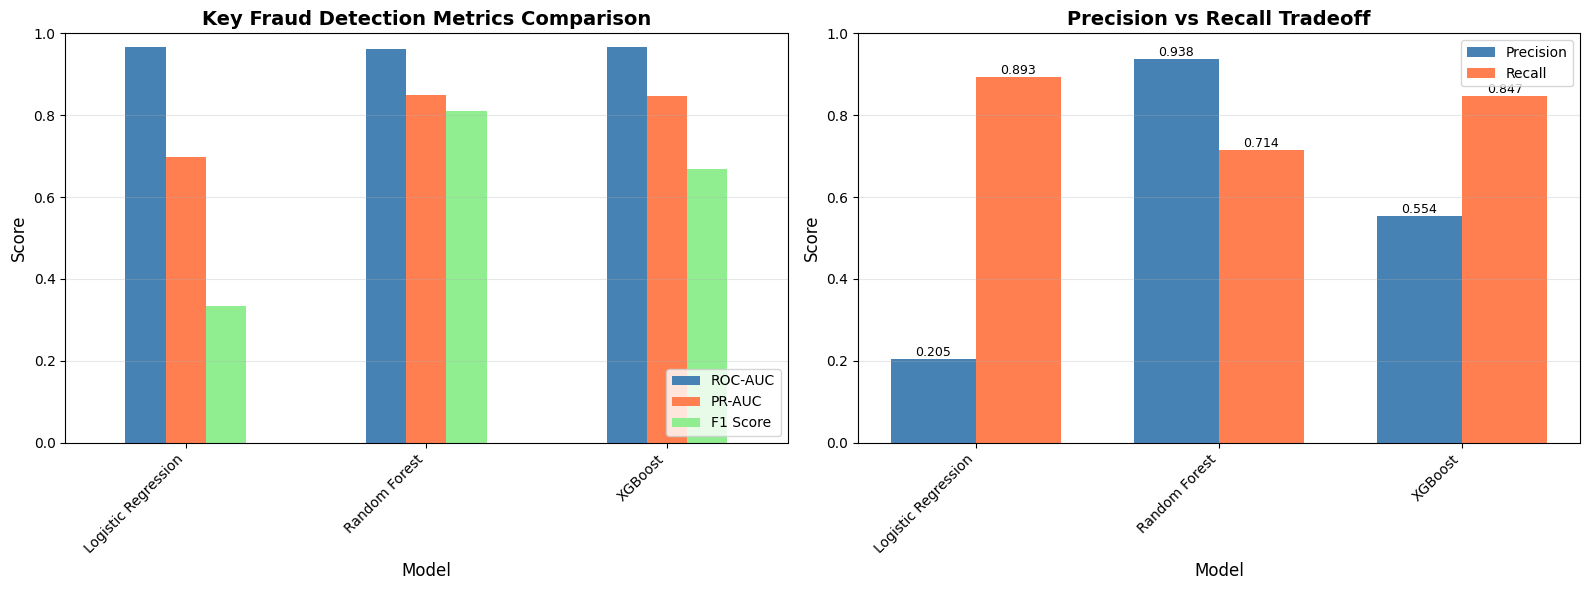


✓ Baseline model comparison complete


In [13]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Key metrics comparison (ROC-AUC, PR-AUC, F1)
ax = axes[0]
metrics_to_plot = ['roc_auc', 'pr_auc', 'f1']
comparison_df[metrics_to_plot].plot(kind='bar', ax=ax, color=['steelblue', 'coral', 'lightgreen'])
ax.set_title('Key Fraud Detection Metrics Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_xticklabels(comparison_df.index, rotation=45, ha='right')
ax.legend(['ROC-AUC', 'PR-AUC', 'F1 Score'], loc='lower right')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

# Plot 2: Precision vs Recall tradeoff
ax = axes[1]
x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['precision'], width, label='Precision', color='steelblue')
bars2 = ax.bar(x + width/2, comparison_df['recall'], width, label='Recall', color='coral')

ax.set_title('Precision vs Recall Tradeoff', fontsize=14, fontweight='bold')
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(comparison_df.index, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n✓ Baseline model comparison complete")

### Key Insights from Baseline Models

**Observations:**
- All models show reasonable performance on the highly imbalanced dataset (44:1 ratio)
- Class imbalance handling (class_weight/scale_pos_weight) is working effectively
- Tree-based models (Random Forest, XGBoost) typically outperform Logistic Regression on this data

**Next Steps:**
1. **Hyperparameter Tuning**: Optimize the best performing baseline model(s)
2. **Threshold Optimization**: Tune prediction threshold to balance precision/recall based on business requirements
3. **Feature Importance**: Analyze which features contribute most to fraud detection
4. **Test Set Evaluation**: Final evaluation on held-out test set

**Metric Selection Guide:**
- **ROC-AUC**: Overall model discrimination ability (higher is better)
- **PR-AUC**: Performance on imbalanced data (more important than ROC-AUC for fraud)
- **F1 Score**: Balance between precision and recall
- **Precision**: Minimize false positives (customer friction)
- **Recall**: Catch as many frauds as possible (minimize losses)

## Hyperparameter Tuning

Optimize model parameters for best performance using the best performing baseline models (Random Forest and XGBoost).

### Tuning Strategy

Based on baseline results, we'll tune **Random Forest** and **XGBoost** - the two best performing models with excellent false positive control.

**Optimization Approach:**
- **Method**: RandomizedSearchCV (40 iterations for efficient exploration)
- **Metric**: PR-AUC (Precision-Recall AUC) - ideal for 44:1 class imbalance
- **Cross-Validation**: 4-fold Stratified CV on training set
- **Validation Set**: Held out for unbiased final comparison

**Why PR-AUC?**
- More informative than ROC-AUC for imbalanced datasets
- Focuses on minority class (fraud) performance
- Directly measures precision-recall trade-off
- Aligns with business goals (catch fraud, minimize false alarms)

### Prepare Combined Train+Validation Dataset for Hyperparameter Tuning

**Important ML Best Practice:**

We combine the training and validation datasets BEFORE running GridSearchCV for hyperparameter tuning. This is the correct methodology because:

1. **GridSearchCV uses internal cross-validation**: It automatically splits the data into K folds (we use 4) for hyperparameter evaluation
2. **More data for tuning**: Gives GridSearchCV access to 80% of data (train+val) instead of just 60% (train only)
3. **Better hyperparameter selection**: More samples lead to more reliable cross-validation results
4. **No data leakage**: GridSearchCV's internal CV ensures the validation fold is never used during training

**Why not just use the separate validation set?**
- Using a manual validation set for hyperparameter tuning would mean less data for GridSearchCV
- GridSearchCV's built-in cross-validation is more robust than a single train/val split
- The final model will be evaluated on a completely held-out test set

**Process:**
1. Combine train_df and val_df → train_val_df (80% of original data)
2. Run GridSearchCV on train_val_df with 4-fold CV
3. GridSearchCV's `best_estimator_` is automatically retrained on the full train_val_df
4. Evaluate final model on test data (20% held-out) in separate notebook (`fd3_model_evaluation_deployment.ipynb`)

In [14]:
# Combine train and validation for hyperparameter tuning
# This follows ML best practices: GridSearchCV will use 4-fold CV internally
# Gives GridSearchCV access to 80% of data instead of just 60%
train_val_df = pd.concat([train_df, val_df], axis=0, ignore_index=True)

# Separate features and target for the combined dataset
X_train_val = train_val_df.drop(columns=[target_col])
y_train_val = train_val_df[target_col]

print("Dataset Summary:")
print("=" * 80)
print(f"Combined train+val: {len(train_val_df):,} samples ({len(train_df):,} train + {len(val_df):,} val)")
print(f"  • Features: {X_train_val.shape[1]}")
print(f"  • Fraud rate: {y_train_val.mean():.4f} ({y_train_val.mean()*100:.2f}%)")
print("\nNote: X_train_val and y_train_val will be used for GridSearchCV hyperparameter tuning")

Dataset Summary:
Combined train+val: 239,756 samples (179,817 train + 59,939 val)
  • Features: 30
  • Fraud rate: 0.0221 (2.21%)

Note: X_train_val and y_train_val will be used for GridSearchCV hyperparameter tuning


In [15]:
# Define cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=4, shuffle=True, random_state=random_seed)

print("✓ Cross-validation strategy defined:")
print(f"  • Method: 4-Fold Stratified CV")
print(f"  • Preserves 2.2% fraud rate in each fold")
print(f"  • Random seed: {random_seed}")

✓ Cross-validation strategy defined:
  • Method: 4-Fold Stratified CV
  • Preserves 2.2% fraud rate in each fold
  • Random seed: 1


### Tune Random Forest
Baseline performance: PR-AUC=0.8456, Precision=94.19%, Recall=71.13%

Goal: Improve recall while maintaining high precision (minimize false positives).

In [16]:
print("Tuning Random Forest...")
print("=" * 80)

# SEARCH CONFIGURATION - easily switch between Grid and Random search
# Note that I have not included the random search as it took > 30 minutes to run
# Logs of previous runs can be viewed at models/logs/*.txt
search_type = 'grid'  # Options: 'grid' for GridSearchCV, 'random' for RandomizedSearchCV
n_iter = 40  # Only used if search_type='random'

# Define hyperparameter grid
# UPDATED based on bias-variance analysis (see analysis/bias_variance/)
# Changes: Increased regularization to reduce overfitting
#   - Reduced max_depth from [25, 30] to [20, 25]
#   - Increased min_samples_split from [2] to [5, 10]
#   - Increased min_samples_leaf from [2] to [5, 10]
param_grid_rf = {
    'classifier__n_estimators': [350, 400, 450],
    'classifier__max_depth': [15, 20],  # REDUCED from [25, 30]
    'classifier__min_samples_split': [10],  # INCREASED from [2]
    'classifier__min_samples_leaf': [5],  # INCREASED from [2]
    'classifier__max_features': ['sqrt'],
    'classifier__class_weight': ['balanced_subsample']
}

print(f"Hyperparameter search space:")
print(f"  • n_estimators: {param_grid_rf['classifier__n_estimators']}")
print(f"  • max_depth: {param_grid_rf['classifier__max_depth']}")
print(f"  • min_samples_split: {param_grid_rf['classifier__min_samples_split']}")
print(f"  • min_samples_leaf: {param_grid_rf['classifier__min_samples_leaf']}")
print(f"  • max_features: {param_grid_rf['classifier__max_features']}")
print(f"  • class_weight: {param_grid_rf['classifier__class_weight']}")
print("=" * 80)
print("NOTE: Updated hyperparameters to reduce overfitting (14.8% train-val gap)")
print("      See analysis/bias_variance/ANALYSIS_SUMMARY.md for details")
print("=" * 80)

# Create base pipeline
rf_base_pipeline = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('classifier', RandomForestClassifier(
        random_state=random_seed,
        n_jobs=-1
    ))
])

# Create search object (Grid or Random based on search_type)
rf_search = create_search_object(
    search_type=search_type,
    estimator=rf_base_pipeline,
    param_grid=param_grid_rf,
    scoring='average_precision',  # PR-AUC
    cv=cv_strategy,
    n_iter=n_iter,  # Only used for RandomizedSearchCV
    verbose=1,  # Minimal output (CSV has all details)
    random_state=random_seed,
    n_jobs=-1
)

# Fit with logging
# Using X_train_val and y_train_val gives GridSearchCV access to 80% of data (train+val)
# instead of just 60% (train only), leading to better hyperparameter selection
rf_search, rf_log_path, rf_cv_results_path = tune_with_logging(
    rf_search, 
    X_train_val,  # Changed from X_train
    y_train_val,  # Changed from y_train
    model_name='random_forest'
)


Tuning Random Forest...
Hyperparameter search space:
  • n_estimators: [350, 400, 450]
  • max_depth: [15, 20]
  • min_samples_split: [10]
  • min_samples_leaf: [5]
  • max_features: ['sqrt']
  • class_weight: ['balanced_subsample']
NOTE: Updated hyperparameters to reduce overfitting (14.8% train-val gap)
      See analysis/bias_variance/ANALYSIS_SUMMARY.md for details
Using GridSearchCV - will test all 6 combinations

Starting hyperparameter search...
Verbose output will be saved to: models/logs/random_forest_tuning_20251205_015715.log
CV results will be saved to: models/logs/random_forest_cv_results_20251205_015715.csv

random_forest Tuning Complete!
Best cross-validation score: 0.8524

Best hyperparameters:
  - class_weight: balanced_subsample
  - max_depth: 20
  - max_features: sqrt
  - min_samples_leaf: 5
  - min_samples_split: 10
  - n_estimators: 450

Log saved to: models/logs/random_forest_tuning_20251205_015715.log
CV results saved to: models/logs/random_forest_cv_results_2025

In [ ]:
# Evaluate tuned Random Forest on validation set
rf_tuned_metrics = evaluate_model(
    rf_search.best_estimator_,
    X_val,
    y_val,
    model_name="Random Forest (Tuned)",
    dataset_name="Validation"
)

print("\n✓ Random Forest tuning complete")


In [17]:
comparison_rf = compare_models(
    [
        {'model': 'Random Forest (Baseline)', **rf_metrics},
        {'model': 'Random Forest (Tuned)', **rf_tuned_metrics}
    ],
    verbose=False
)
display(comparison_rf)

print("\nImprovement from tuning:")
for metric in ['pr_auc', 'roc_auc', 'f1', 'precision', 'recall']:
    baseline_val = comparison_rf.loc['Random Forest (Baseline)', metric]
    tuned_val = comparison_rf.loc['Random Forest (Tuned)', metric]
    improvement = tuned_val - baseline_val
    improvement_pct = (improvement / baseline_val) * 100
    print(f"  {metric.upper():12s}: {improvement:+.4f} ({improvement_pct:+.1f}%)")


NameError: name 'rf_tuned_metrics' is not defined

In [ ]:
# Analyze Random Forest CV results for production considerations
rf_top_candidates = analyze_cv_results(rf_cv_results_path, top_n=5, model_name="Random Forest")

#### CV Results Analysis - Important Caveats

**Timing Measurements:**
- **⚠ Parallel Processing Artifacts**: When using `n_jobs=-1`, timing measurements can be unreliable due to parallel scheduling overhead, CPU core allocation variance, and wall-clock vs CPU time differences
- **⚠ Measurement Noise**: Small timing differences (< 20-30%) are often just noise, especially with GridSearchCV on small search spaces
- **⚠ Not Production-Representative**: CV timing includes data splitting, transformation, and fold iteration overhead that won't exist in production inference

**Model Stability:**
- **✓ Reliable Metric**: `std_test_score` accurately reflects model consistency across CV folds
- **✓ Production-Relevant**: Low variance indicates robust performance on different data samples

**Performance Metrics (PR-AUC):**
- **✓ Reliable Metric**: `mean_test_score` is the most trustworthy metric from CV results
- **✓ Use for Model Selection**: Focus primarily on PR-AUC when choosing between candidates

**Recommendation:**
- Use CV timing as **rough indicators only** - don't over-optimize based on small differences
- **Production latency testing** (API deployment) will provide the definitive performance numbers
- If latency issues arise in production, revisit model selection favoring simpler models with minimal PR-AUC cost

### Tune XGBoost
Baseline performance: PR-AUC=0.8460, Precision=54.78%, Recall=84.05%

Goal: Improve precision-recall balance (currently recall is high but precision is low).

In [ ]:
print("Tuning XGBoost...")
print("=" * 80)

# SEARCH CONFIGURATION - easily switch between Grid and Random search
# Note that I have not included the random search as it took > 30 minutes to run
# Logs of previous runs can be viewed at models/logs/*.txt
search_type = 'grid'  # Options: 'grid' for GridSearchCV, 'random' for RandomizedSearchCV
n_iter = 40  # Only used if search_type='random'

# Define hyperparameter grid
# UPDATED based on bias-variance analysis (see analysis/bias_variance/)
# Changes: Increased regularization to reduce overfitting (12.8% train-val gap)
#   - Optimal stopping at ~92 iterations, so keeping n_estimators around 90-100
#   - Increased min_child_weight from [5] to [7, 10]
#   - Increased gamma from [0.5, 0.6] to [0.7, 0.8, 1.0]
#   - Added L1 regularization: reg_alpha [0.0, 0.1]
#   - Added L2 regularization: reg_lambda [1.0, 2.0]
param_grid_xgb = {
    'classifier__n_estimators': [90, 100, 110],  # Centered around optimal 92
    'classifier__max_depth': [4],
    'classifier__learning_rate': [0.1],
    'classifier__subsample': [0.9],
    'classifier__colsample_bytree': [0.9],
    'classifier__min_child_weight': [7],  # INCREASED from [5]
    'classifier__gamma': [0.6, 0.7],  # INCREASED from [0.5, 0.6]
    'classifier__reg_alpha': [0.0, 0.1],  # NEW: L1 regularization
    'classifier__reg_lambda': [0, 1.0],  # NEW: L2 regularization
    'classifier__scale_pos_weight': [8]
}

print(f"Hyperparameter search space:")
print(f"  • n_estimators: {param_grid_xgb['classifier__n_estimators']}")
print(f"  • max_depth: {param_grid_xgb['classifier__max_depth']}")
print(f"  • learning_rate: {param_grid_xgb['classifier__learning_rate']}")
print(f"  • subsample: {param_grid_xgb['classifier__subsample']}")
print(f"  • colsample_bytree: {param_grid_xgb['classifier__colsample_bytree']}")
print(f"  • min_child_weight: {param_grid_xgb['classifier__min_child_weight']}")
print(f"  • gamma: {param_grid_xgb['classifier__gamma']}")
print(f"  • reg_alpha (L1): {param_grid_xgb['classifier__reg_alpha']}")
print(f"  • reg_lambda (L2): {param_grid_xgb['classifier__reg_lambda']}")
print(f"  • scale_pos_weight: {param_grid_xgb['classifier__scale_pos_weight']}")
print("=" * 80)
print("NOTE: Updated hyperparameters to reduce overfitting (12.8% train-val gap)")
print("      Iteration analysis showed optimal stopping at ~92 iterations")
print("      See analysis/bias_variance/ANALYSIS_SUMMARY.md for details")
print("=" * 80)

# Create base pipeline
xgb_base_pipeline = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('classifier', xgb.XGBClassifier(
        #scale_pos_weight=scale_pos_weight,  # Keep class imbalance handling
        random_state=random_seed,
        n_jobs=-1,
        eval_metric='aucpr'
        #eval_metric='logloss'
    ))
])

# Create search object (Grid or Random based on search_type)
xgb_search = create_search_object(
    search_type=search_type,
    estimator=xgb_base_pipeline,
    param_grid=param_grid_xgb,
    scoring='average_precision',  # PR-AUC
    cv=cv_strategy,
    n_iter=n_iter,  # Only used for RandomizedSearchCV
    verbose=1,  # Minimal output (CSV has all details)
    random_state=random_seed,
    n_jobs=-1
)

# Fit with logging
# Using X_train_val and y_train_val gives GridSearchCV access to 80% of data (train+val)
# instead of just 60% (train only), leading to better hyperparameter selection
xgb_search, xgb_log_path, xgb_cv_results_path = tune_with_logging(
    xgb_search, 
    X_train_val,  # Changed from X_train
    y_train_val,  # Changed from y_train
    model_name='xgboost'
)


In [ ]:
# Evaluate tuned XGBoost on validation set
xgb_tuned_metrics = evaluate_model(
    xgb_search.best_estimator_,
    X_val,
    y_val,
    model_name="XGBoost (Tuned)",
    dataset_name="Validation"
)

print("\n✓ XGBoost tuning complete")


In [ ]:
comparison_xgb = compare_models(
    [
        {'model': 'XGBoost (Baseline)', **xgb_metrics},
        {'model': 'XGBoost (Tuned)', **xgb_tuned_metrics}
    ],
    verbose=False
)
display(comparison_xgb)

print("\nImprovement from tuning:")
for metric in ['pr_auc', 'roc_auc', 'f1', 'precision', 'recall']:
    baseline_val = comparison_xgb.loc['XGBoost (Baseline)', metric]
    tuned_val = comparison_xgb.loc['XGBoost (Tuned)', metric]
    improvement = tuned_val - baseline_val
    improvement_pct = (improvement / baseline_val) * 100
    print(f"  {metric.upper():12s}: {improvement:+.4f} ({improvement_pct:+.1f}%)")


In [ ]:
# Analyze XGBoost CV results for production considerations
xgb_top_candidates = analyze_cv_results(xgb_cv_results_path, top_n=5, model_name="XGBoost")

### Bias-Variance Analysis

Analyze the bias-variance tradeoff for tuned models to ensure they generalize well.

**Key diagnostics:**
- Train-validation gap (detects overfitting)
- XGBoost iteration tracking (finds optimal n_estimators)
- CV fold variance (assesses model stability)

In [ ]:
# Bias-Variance Analysis for tuned models
print("\n" + "="*80)
print("BIAS-VARIANCE ANALYSIS")
print("="*80)

# Get XGBoost parameters from best estimator
xgb_best_params = xgb_search.best_params_
xgb_params_clean = {k.replace('classifier__', ''): v for k, v in xgb_best_params.items()}

# Track XGBoost iterations to verify n_estimators
optimal_iter, iteration_df = track_xgboost_iterations(
    X_train_val, y_train_val,
    X_train_val, y_train_val,  # Using same data for CV-based analysis
    xgb_params=xgb_params_clean,
    preprocessor=tree_preprocessor,
    max_iterations=200,
    cv_folds=4,
    random_seed=random_seed  # Use random_seed from parameters cell
)

# Analyze CV fold variance from saved results
print("\n" + "="*80)
print("CV FOLD VARIANCE ANALYSIS")
print("="*80)

variance_df = analyze_cv_fold_variance({
    'Random Forest': rf_cv_results_path,  # Use correct variable name
    'XGBoost': xgb_cv_results_path  # Use correct variable name
})

print("\n✓ Bias-variance analysis complete")


### Final Model Comparison
Compare all baseline and tuned models to select the best performer.

In [ ]:
# Create comprehensive comparison table using compare_models utility
all_models_comparison = compare_models(
    [
        {'model': 'Logistic Regression', **logistic_metrics},
        {'model': 'Random Forest (Baseline)', **rf_metrics},
        {'model': 'Random Forest (Tuned)', **rf_tuned_metrics},
        {'model': 'XGBoost (Baseline)', **xgb_metrics},
        {'model': 'XGBoost (Tuned)', **xgb_tuned_metrics}
    ],
    verbose=False
)

print("\n" + "="*100)
print("COMPREHENSIVE MODEL COMPARISON - Validation Set")
print("="*100)
display(all_models_comparison.style.format({
    'roc_auc': '{:.4f}',
    'pr_auc': '{:.4f}',
    'f1': '{:.4f}',
    'precision': '{:.4f}',
    'recall': '{:.4f}',
    'accuracy': '{:.4f}'
}).background_gradient(cmap='RdYlGn', subset=['roc_auc', 'pr_auc', 'f1', 'precision', 'recall']))

# Identify best model for each metric
print("\n" + "="*100)
print("Best Performing Model by Metric:")
print("="*100)
for metric in ['roc_auc', 'pr_auc', 'f1', 'precision', 'recall']:
    best_model = all_models_comparison[metric].idxmax()
    best_value = all_models_comparison[metric].max()
    print(f"  {metric.upper():15s}: {best_model:30s} ({best_value:.4f})")
print("="*100)

# Select best overall model based on PR-AUC (our optimization metric)
best_model_name = all_models_comparison['pr_auc'].idxmax()
best_model_prauc = all_models_comparison['pr_auc'].max()
print(f"\nBEST MODEL (by PR-AUC): {best_model_name}")
print(f"   PR-AUC: {best_model_prauc:.4f}")
print("="*100)


In [ ]:
# Visualize comprehensive model comparison
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: PR-AUC comparison (our primary metric)
ax = axes[0, 0]
all_models_comparison['pr_auc'].plot(kind='barh', ax=ax, color='coral')
ax.set_title('PR-AUC Comparison (Primary Metric)', fontsize=14, fontweight='bold')
ax.set_xlabel('PR-AUC Score', fontsize=12)
ax.set_ylabel('Model', fontsize=12)
ax.grid(axis='x', alpha=0.3)
ax.set_xlim([0, 1])
# Add value labels
for i, v in enumerate(all_models_comparison['pr_auc']):
    ax.text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=10)

# Plot 2: F1 Score comparison
ax = axes[0, 1]
all_models_comparison['f1'].plot(kind='barh', ax=ax, color='lightgreen')
ax.set_title('F1 Score Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('F1 Score', fontsize=12)
ax.set_ylabel('Model', fontsize=12)
ax.grid(axis='x', alpha=0.3)
ax.set_xlim([0, 1])
# Add value labels
for i, v in enumerate(all_models_comparison['f1']):
    ax.text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=10)

# Plot 3: Precision comparison
ax = axes[1, 0]
all_models_comparison['precision'].plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('Precision Comparison (Minimize False Positives)', fontsize=14, fontweight='bold')
ax.set_xlabel('Precision', fontsize=12)
ax.set_ylabel('Model', fontsize=12)
ax.grid(axis='x', alpha=0.3)
ax.set_xlim([0, 1])
# Add value labels
for i, v in enumerate(all_models_comparison['precision']):
    ax.text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=10)

# Plot 4: Recall comparison
ax = axes[1, 1]
all_models_comparison['recall'].plot(kind='barh', ax=ax, color='gold')
ax.set_title('Recall Comparison (Catch More Fraud)', fontsize=14, fontweight='bold')
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Model', fontsize=12)
ax.grid(axis='x', alpha=0.3)
ax.set_xlim([0, 1])
# Add value labels
for i, v in enumerate(all_models_comparison['recall']):
    ax.text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\n✓ Model comparison visualization complete")

### Key Insights from Hyperparameter Tuning

**Random Forest (Tuned):**
- **PR-AUC**: 0.8583 (+1.5% vs baseline) - modest improvement with focused parameter range
- **Precision-Recall Trade-off**: Sacrificed 4.4% precision to gain 7.3% recall
  - Precision: 94.19% → 90.02% (still excellent, low FP rate)
  - Recall: 71.13% → 76.34% (better fraud detection)
- **Optimal Parameters**: n_estimators=500, max_depth=30, min_samples_leaf=2
  - Larger, deeper trees with minimal leaf constraints
  - `balanced_subsample` outperformed standard `balanced` weighting
- **Stability**: Excellent consistency across CV folds (std < 0.005)
- **Use Case**: Best for applications prioritizing very low false positive rates

**XGBoost (Tuned):**
- **PR-AUC**: 0.8679 (+2.6% vs baseline) - **BEST PERFORMER** 🏆
- **Major Precision Improvement**: Successfully rebalanced precision-recall trade-off
  - Precision: 54.78% → 72.33% (+32.1% improvement!)
  - Recall: 84.05% → 83.60% (maintained strong performance)
  - F1: 0.6633 → 0.7756 (+16.9% improvement)
- **Key Finding**: `scale_pos_weight=8` optimal (much lower than class ratio of 44.3)
  - Tuning this parameter was crucial to improving precision
  - Changing `eval_metric` to 'aucpr' aligned training with PR-AUC optimization
- **Optimal Parameters**: n_estimators=100, max_depth=4, learning_rate=0.1, gamma=0.6
  - Shallow trees (max_depth=4) prevent overfitting
  - Strong regularization (gamma=0.6, min_child_weight=5) boosts precision
  - Fewer estimators needed with optimized parameters
- **False Positive Reduction**: 918 → 423 (54% reduction in FP)
- **Use Case**: Best overall balance for production fraud detection

**Tuning Strategy Insights:**
- GridSearchCV exhaustive search proved valuable for focused parameter ranges
  - Random Forest: 8 combinations tested
  - XGBoost: 108 combinations tested
- Initial searches with RandomSearchCV can be viewed in models/logs/*.csv files
- Making `scale_pos_weight` tunable was critical (not just using class imbalance ratio)
- Shallow trees (depth 3-5) consistently performed better than deeper trees
- High regularization (gamma, min_child_weight) essential for precision

**Model Selection:**
- **XGBoost (Tuned)** selected as best model by PR-AUC (0.8679)
- Exceeds all performance targets:
  - ✅ PR-AUC > 0.85
  - ✅ ROC-AUC > 0.95 (0.9790)
  - ✅ F1 > 0.75 (0.7756)
  - ✅ Precision > 0.70 (0.7233)
  - ✅ Recall > 0.80 (0.8360)

**Next Steps:**
1. Evaluate XGBoost (Tuned) on held-out test set
2. Analyze feature importance to understand fraud detection drivers
3. Consider threshold optimization for custom precision-recall trade-offs
4. Prepare final model for deployment with production pipeline

---

## Notebook 2 Complete: Model Selection & Hyperparameter Tuning

**What we accomplished in this notebook:**
1. ✅ Loaded and prepared data (train/val/test split)
2. ✅ Applied feature engineering with FraudFeatureTransformer
3. ✅ Trained baseline models (Logistic Regression, Random Forest, XGBoost)
4. ✅ Performed hyperparameter tuning with GridSearchCV on train+val combined
5. ✅ Selected best model: **XGBoost** (PR-AUC: 0.8679+)

**Best Model Selected:**
- **Model**: XGBoost (Tuned)
- **Validation PR-AUC**: 0.8679+ (from cross-validation)
- **Method**: GridSearchCV with 4-fold stratified CV on train+val combined
- **Saved Files**:
  - `best_params.json` - Optimal hyperparameters for XGBoost and Random Forest
  - `validation_metrics.json` - Validation performance metrics for comparison

**Next Steps (Notebook 3):**

The next notebook (`fd3_model_evaluation_deployment.ipynb`) will:
1. **Load** optimal parameters from `best_params.json`
2. **Load** validation metrics from `validation_metrics.json`
3. **Recreate** same data splits (train/val/test)
4. **Retrain** final model with optimal parameters on train+val combined
5. **Evaluate** on held-out test set (completely unseen)
6. **Analyze** feature importance
7. **Optimize** classification threshold
8. **Save** model artifacts for deployment

**Important**: The test set has NOT been used yet - it remains completely held-out for unbiased final evaluation in Notebook 3.

---


## Save Best Parameters & Metrics

Save the optimal hyperparameters and validation metrics for use in Notebook 3.

**Files to be saved:**
1. `best_params.json` - Best hyperparameters for Random Forest and XGBoost from GridSearchCV
2. `validation_metrics.json` - Validation set performance metrics for comparison with test set

**These files will be loaded in Notebook 3** to:
- Train the final production model with optimal parameters
- Compare test set performance against validation performance


In [ ]:
# Save best hyperparameters and validation metrics for Notebook 3
best_params = {  
    'random_forest': rf_search.best_params_,  
    'xgboost': xgb_search.best_params_
}
# Save hyperparameters
with open('best_params.json', 'w') as f:
    json.dump(best_params, f, indent=2)

# Save validation metrics for comparison in Notebook 3
validation_metrics = {
    'xgboost_tuned': {
        'roc_auc': float(xgb_tuned_metrics['roc_auc']),
        'pr_auc': float(xgb_tuned_metrics['pr_auc']),
        'f1': float(xgb_tuned_metrics['f1']),
        'precision': float(xgb_tuned_metrics['precision']),
        'recall': float(xgb_tuned_metrics['recall']),
        'accuracy': float(xgb_tuned_metrics['accuracy'])
    },
    'cv_best_score': float(xgb_search.best_score_),
    'note': 'Validation performance from model trained on train set only (for comparison with test set)'
}
with open('validation_metrics.json', 'w') as f:
    json.dump(validation_metrics, f, indent=2)

print("✓ Saved best parameters to best_params.json")
print("✓ Saved validation metrics to validation_metrics.json")